# Data Analysis

Here we analyse the data we gathered from testing our agent in many different contexts

In [ ]:
import csv
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

RESULTS_DIR = Path("results")

In [ ]:
def format_plot(filename, title='', xlabel='', ylabel='', padding=110, reference=0, relative=False):
    filepath = RESULTS_DIR / filename
    x, y = [], []

    try:
        with filepath.open('r') as file:
            csvreader = csv.reader(file)
            for row in csvreader:
                x.append(row[0])
                y.append(float(row[1]))

        if reference > 0:
            z = [reference for _ in range(len(x))]
            plt.plot(x, z, '--', color='black', label='theoretical maximum')
        if reference == -1:
            z = [int(x[i]) / 2.5 - 1 for i in range(len(x))]
            plt.plot(x, z, '--', color='black', label='theoretical maximum')

        if relative:
            for i in range(len(x)):
                y[i] = abs(int(x[i]) / 2.5 - 1 - y[i])
        plt.plot(x, y, 'o', color='black', label='simulation result')

        if y:
            y_min, y_max = min(y), max(y)
            margin = (y_max - y_min) * padding
            if margin == 0:
                plt.ylim(y_min - 1, y_min + 1)
            else:
                plt.ylim(y_min - margin, y_max + margin)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.show()

    except FileNotFoundError:
        print(f"Error: '{filepath}' not found.")
    except ValueError:
        print("Error: Could not convert data to numbers.")

## 1. Bandwidth analysis

In [ ]:
format_plot('benchmark_bandwidth.csv',
            title='Benchmark Bandwidth',
            xlabel='bandwidth',
            ylabel='score',
            reference=199,
            padding=100)

## 2. MaxIter analysis

In [ ]:
format_plot('benchmark_iterations.csv',
            title='Benchmark MaxIter',
            xlabel='maximum number of iterations',
            ylabel='score',
            reference=199,
            padding=1)

## STALE: max_iter averaged

> **Note:** `benchmark_max_iterations_averaged.csv` no longer exists. This cell is kept for reference only.

In [ ]:
# STALE: benchmark_max_iterations_averaged.csv no longer exists
# format_plot('benchmark_max_iterations_averaged.csv',
#             title='Benchmark MaxIter',
#             xlabel='maximum number of iterations',
#             ylabel='score',
#             reference=799,
#             padding=1)

## 3. Pitch Adjustment Rate

In [ ]:
format_plot('benchmark_pitch_adj_rate.csv',
            title='Benchmark Pitch Adjustment Rate',
            xlabel='rate',
            ylabel='score',
            reference=199,
            padding=100)

## 4. Consistency Test
Given a set of weight obtained in 100 iterations, how good does it perform in games of increasing length?

In [ ]:
format_plot('consistency.csv',
            title='Consistency Test',
            xlabel='game length',
            ylabel='score',
            reference=-1,
            padding=0.1)

In [ ]:
format_plot('consistency.csv',
            title='Consistency Test: Absolute Error',
            xlabel='game length',
            ylabel='absolute error',
            relative=True,
            padding=0.1)

## 5. Weight Analysis

In [ ]:
df = pd.read_csv(RESULTS_DIR / 'optimized_weights.csv')

target_cols = [f'w{i}' for i in range(1, 17)]

means = df[target_cols].mean()
stds = df[target_cols].std()

plt.figure(figsize=(12, 6))
plt.bar(target_cols, means, yerr=stds, capsize=5, color='skyblue', edgecolor='navy', alpha=0.8)
plt.xlabel('Weight Columns')
plt.ylabel('Average Value')
plt.title('Mean and Standard Deviation for w1 through w16')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

stats_summary = pd.DataFrame({'Mean': means, 'Std Dev': stds})
print(stats_summary)

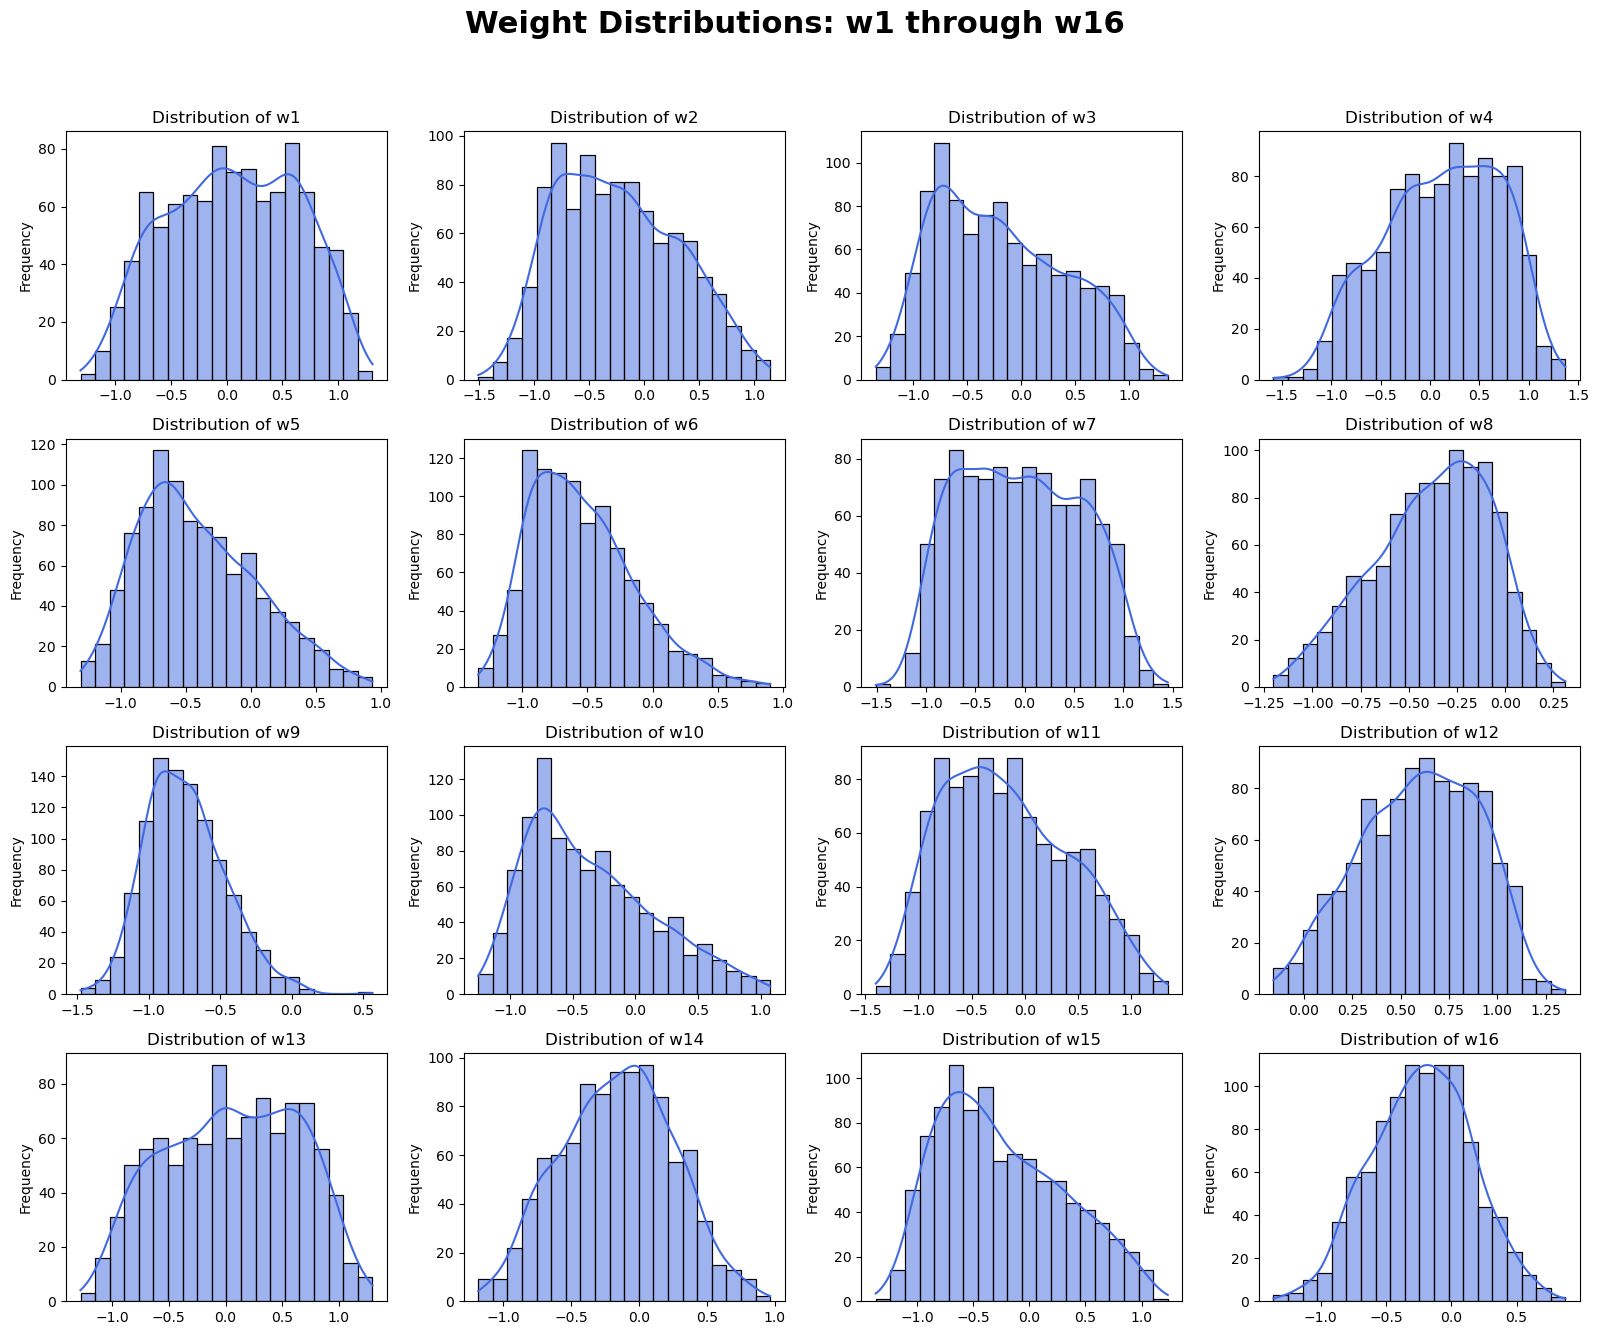

In [4]:
# Setup the figure and a 4x4 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 14))
fig.suptitle('Weight Distributions: w1 through w16', fontsize=22, fontweight='bold')

# Define our column names
target_cols = [f'w{i}' for i in range(1, 17)]

# Flatten the axes array (from 4x4 to a 1D list of 16) to loop easily
axes_flat = axes.flatten()

# Loop through each column and create a histogram
for i, col in enumerate(target_cols):
    sns.histplot(df[col], kde=True, ax=axes_flat[i], color='royalblue', bins=20)
    
    # Clean up titles and labels for a professional look
    axes_flat[i].set_title(f'Distribution of {col}', fontsize=12)
    axes_flat[i].set_xlabel('')
    axes_flat[i].set_ylabel('Frequency')

# Automatically adjust spacing so titles don't overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Leaves space for the main title
plt.show()

In [5]:

from scipy.spatial.distance import pdist, squareform

# 1. Define the columns that form your vectors
target_cols = ['w' + str(i) for i in range(1, 17)]

# 2. Extract the data as a matrix of vectors (N rows x 16 columns)
vectors = df[target_cols].values

# 3. Calculate pairwise Euclidean distances
# pdist computes the distance between every pair of rows
distances = pdist(vectors, metric='euclidean')

# 4. Convert the condensed distance array into a square matrix
dist_matrix = squareform(distances)

# 5. Mask the lower triangle to create the upper triangular matrix
# np.triu(m) zeros out all elements below the main diagonal
upper_tri_dist_matrix = np.triu(dist_matrix)

# Optional: Convert to a DataFrame for better labeling
dist_df = pd.DataFrame(upper_tri_dist_matrix)

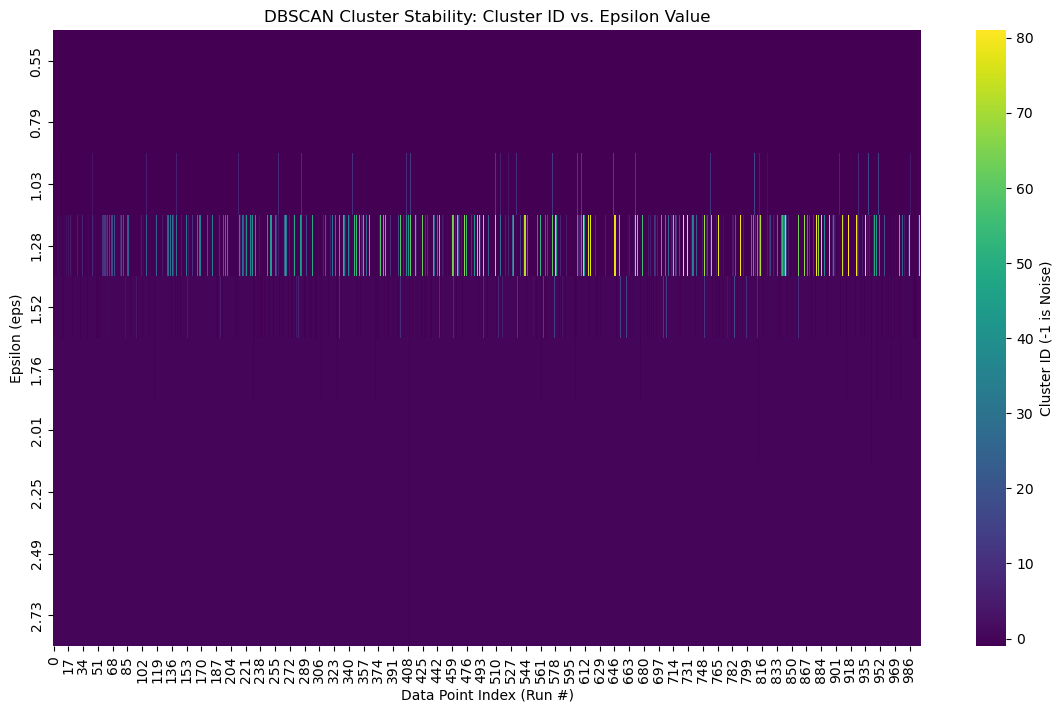

In [8]:
#Stacked Cluster Map

# Convert your Upper Triangular Matrix to a Full Symmetric Matrix
# (Assumes your matrix is named 'upper_tri_dist_matrix')
full_dist_matrix = upper_tri_dist_matrix + upper_tri_dist_matrix.T

# Look at the mean of non-zero distances to get a sense of the scale
avg_dist = full_dist_matrix[full_dist_matrix > 0].mean()

# Setup parameters
# Using a range of eps values
eps_values = np.linspace(avg_dist * 0.2, avg_dist, 10) 
cluster_history = []

# Run DBSCAN multiple times
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=2, metric='precomputed')
    labels = dbscan.fit_predict(full_dist_matrix)
    cluster_history.append(labels)

# Create a DataFrame for visualization
# Rows = different eps values, Columns = data points
history_df = pd.DataFrame(cluster_history, index=np.round(eps_values, 2))

# Plotting the results
plt.figure(figsize=(14, 8))
sns.heatmap(history_df, cmap='viridis', cbar_kws={'label': 'Cluster ID (-1 is Noise)'})

plt.title('DBSCAN Cluster Stability: Cluster ID vs. Epsilon Value')
plt.xlabel('Data Point Index (Run #)')
plt.ylabel('Epsilon (eps)')
plt.show()

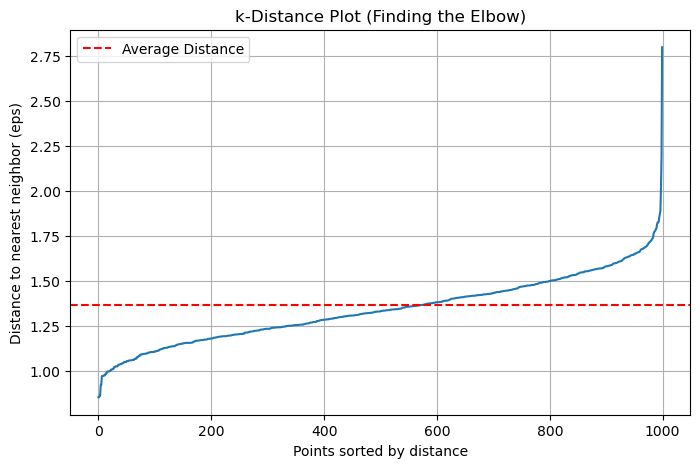

In [7]:
# Elbow Method For DBSCAN
# Calculate distances to the nearest neighbor (k=1 because min_samples=2)
# We take the full_dist_matrix and sort each row
nearest_neighbor_distances = np.sort(full_dist_matrix, axis=1)[:, 1]
sorted_distances = np.sort(nearest_neighbor_distances)

plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.axhline(y=avg_dist/2, color='r', linestyle='--', label='Average Distance')
plt.title('k-Distance Plot (Finding the Elbow)')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to nearest neighbor (eps)')
plt.legend()
plt.grid(True)
plt.show()

## STALE: Solvers comparison

> **Note:** `comparison_harmony_crossentropy.csv` no longer exists. These cells are kept for reference only.

In [ ]:
# STALE: comparison_harmony_crossentropy.csv no longer exists
# x, y, z, h, k = [], [], [], [], []
# with open("comparison_harmony_crossentropy.csv", 'r') as file:
#     csvreader = csv.reader(file)
#     for row in csvreader:
#         y.append(float(row[2]))
#         z.append(float(row[4]))
#         h.append(float(row[6]))
#         k.append(float(row[8]))
#         x.append(float(row[0]))
# plt.plot(x, y, 'o', label='accurate HS')
# plt.plot(x, h, '>', label='fast CES')
# plt.plot(x, z, '+', label='accurate CES')
# plt.plot(x, k, '*', label='fast HS')
# plt.legend(loc='upper right')
# plt.xlabel('iteration')
# plt.ylabel('Time (s)')
# plt.title('Speed comparison between algorithms')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

In [ ]:
# STALE: comparison_harmony_crossentropy.csv no longer exists
# x, y, z, h, k = [], [], [], [], []
# with open("comparison_harmony_crossentropy.csv", 'r') as file:
#     csvreader = csv.reader(file)
#     for row in csvreader:
#         y.append(float(row[1]))
#         z.append(float(row[3]))
#         h.append(float(row[5]))
#         k.append(float(row[7]))
#         x.append(float(row[0]))
# plt.plot(x, y, 'o', label='accurate HS')
# plt.plot(x, h, '>', label='fast CES')
# plt.plot(x, z, '+', label='accurate CES')
# plt.plot(x, k, '*', label='fast HS')
# plt.legend()
# plt.xlabel('iteration')
# plt.ylabel('Score')
# plt.title('Score comparison between algorithms')
# plt.grid(axis='y', linestyle='--', alpha=0.7)